In [1]:
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from utilities.storage import get_dot_product_bm25_selected_files, get_dot_product_bm25_selected_model_generated_files
from utilities.model import get_model

In [2]:
def calculate_cosine_similarity(a_dot_b, a_dot_a, b_dot_b):
    # calculates the cosine similarity based on dot products
    return a_dot_b / (math.sqrt(a_dot_a) * math.sqrt(b_dot_b))

In [3]:
def calculate_score(gradient_similarities: dict):
    correct_counter = 0
    bm25_correct_counter = 0

    size = len(gradient_similarities.keys())

    for paraphrased_id, similarities in gradient_similarities.items():
        most_similar_original_id = max(similarities, key=similarities.get)
        correct_counter += int(paraphrased_id == most_similar_original_id)

        bm25_most_similar_original_id = list(similarities.keys())[0]
        bm25_correct_counter += int(paraphrased_id == bm25_most_similar_original_id)

    return correct_counter / size, bm25_correct_counter / size

In [4]:
def get_wrong_decisions(gradient_similarities: dict):
    wrong_decisions = []

    for original_id, similarities in gradient_similarities.items():
        most_similar_paraphrased_id = max(similarities, key=similarities.get)
        if original_id != most_similar_paraphrased_id:
            wrong_decisions.append(original_id)

    return wrong_decisions

In [5]:
def get_mean_similarity_of_most_similar_samples(gradient_similarities: dict, mean_function = np.mean):
    highest_similarities = []

    for original_id, similarities in gradient_similarities.items():
        highest_similarities.append(max(similarities.values()))

    return mean_function(highest_similarities)

In [6]:
def get_cosine_similarities(dot_product_storage_function, model_to_evaluate, sample_size):
    dot_products, paraphrased_dot_products, original_dot_products = dot_product_storage_function(model_to_evaluate, sample_size)

    # restructure such that layer is at outermost level in the dictionary for easier access afterward
    cosine_similarities_new_structure = dict()
    cosine_similarities_old_structure = dict()

    cosine_similarities_old_structure_combined = dict() # all gradients combined

    for paraphrased_id, values in dot_products.items():
        cosine_similarities_old_structure[paraphrased_id] = dict()
        cosine_similarities_old_structure_combined[paraphrased_id] = dict()

        for original_id, layers in values.items():
            cosine_similarities_old_structure[paraphrased_id][original_id] = dict()
            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = 0

            for layer, value in layers.items():
                if layer not in cosine_similarities_new_structure:
                    cosine_similarities_new_structure[layer] = dict()

                if paraphrased_id not in cosine_similarities_new_structure[layer]:
                    cosine_similarities_new_structure[layer][paraphrased_id] = dict()

                similarity = calculate_cosine_similarity(value, paraphrased_dot_products[paraphrased_id][layer], original_dot_products[original_id][layer])

                cosine_similarities_old_structure[paraphrased_id][original_id][layer] = similarity
                cosine_similarities_new_structure[layer][paraphrased_id][original_id] = similarity

                cosine_similarities_old_structure_combined[paraphrased_id][original_id] += value

            cosine_similarities_old_structure_combined[paraphrased_id][original_id] = calculate_cosine_similarity(
                cosine_similarities_old_structure_combined[paraphrased_id][original_id],
                sum(paraphrased_dot_products[paraphrased_id].values()),
                sum(original_dot_products[original_id].values())
            )

    # check if restructuring has worked by comparing iteratively with gradient_similarities dictionary
    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            for original_id, similarity in original_ids.items():
                assert similarity == cosine_similarities_old_structure[paraphrased_id][original_id][layer]

    return cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined

In [7]:
def calculate_accuracy_per_layer(cosine_similarities_new_structure: dict):
    correct_counter_per_layer = defaultdict(int)

    # amount of paraphrased_samples
    size = len(next(iter(cosine_similarities_new_structure.values())).keys())

    for layer, values in cosine_similarities_new_structure.items():
        for paraphrased_id, original_ids in values.items():
            most_similar_original_id = max(original_ids, key=original_ids.get)
            correct_counter_per_layer[layer] += int(paraphrased_id == most_similar_original_id)

        # divide by size to get percentage
        correct_counter_per_layer[layer] /= size

    return correct_counter_per_layer

In [8]:
#model_to_evaluate = "amd/AMD-OLMo-1B-SFT"
#model_to_evaluate = "allenai/OLMo-7B-SFT-hf"
#sample_size = 100

model_to_evaluate = "openai-community/gpt2"
sample_size = 3

In [9]:
model = get_model(model_to_evaluate)
layer_amount_parameters = {name: tensor.numel() for name, tensor in model.state_dict().items()}

Device: cpu
Model parameters: 124439808
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [10]:
sum_parameters = 0
for num in layer_amount_parameters.values():
    sum_parameters += num

print(model.num_parameters())
print(sum_parameters)


124439808
163037184


In [11]:
cosine_similarities_new_structure, cosine_similarities_old_structure, cosine_similarities_old_structure_combined = get_cosine_similarities(get_dot_product_bm25_selected_files, model_to_evaluate, sample_size)

In [12]:
import pprint

pprint.pprint(cosine_similarities_old_structure_combined, indent=4, sort_dicts=False)

{   'lima_0': {   'lima_0': 0.543149617675471,
                  'lima_451': 0.019011601541314625,
                  'lima_266': -0.007782182334886855,
                  'lima_947': 0.03477175810341472,
                  'lima_110': 0.0919314673549259},
    'lima_1': {   'lima_1': 0.5040566408410335,
                  'lima_122': 0.05884385681214322,
                  'lima_22': -0.006850888517972179,
                  'lima_337': 0.04565171222971818,
                  'lima_290': 0.010580813582932933},
    'lima_2': {   'lima_2': 0.8746565012016682,
                  'lima_162': 0.1442209479522065,
                  'lima_44': 0.06581968878305666,
                  'lima_1': 0.009595156058502512,
                  'lima_94': 0.032934485305843995}}


In [13]:
a = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))
b = np.array(list(cosine_similarities_old_structure_combined["lima_0"].values()))

similarity = cosine_similarity(X=a.reshape(1, -1), Y=b.reshape(1, -1))

print(similarity)
print(similarity[0][0])

[[1.]]
0.9999999999999997


In [14]:
# compare with full gradient

# flatten full gradient similarities for comparisons
full_flattened = [item for values in cosine_similarities_old_structure_combined.values() for item in values.values()]

layer_similarity_compared_to_full_gradients = dict()

for layer, similarities in cosine_similarities_new_structure.items():
    layer_cosine_similarities_flattened = []

    for paraphrased_id, original_similarities in similarities.items():
        layer_cosine_similarities_flattened.extend(original_similarities.values())

    layer_similarity_compared_to_full_gradients[layer] = cosine_similarity(X=[layer_cosine_similarities_flattened], Y=[full_flattened])[0][0]

In [15]:
pprint.pprint(layer_similarity_compared_to_full_gradients, indent=4, sort_dicts=False)

{   'transformer.wte.weight': 0.9998289131962147,
    'transformer.wpe.weight': 0.8251278228696561,
    'transformer.h.0.ln_1.weight': 0.6008165914068285,
    'transformer.h.0.ln_1.bias': 0.90836825959234,
    'transformer.h.0.attn.c_attn.weight': 0.9648933485823064,
    'transformer.h.0.attn.c_attn.bias': 0.8328510747133405,
    'transformer.h.0.attn.c_proj.weight': 0.9778052936349293,
    'transformer.h.0.attn.c_proj.bias': 0.9529360320330327,
    'transformer.h.0.ln_2.weight': 0.6764567281997907,
    'transformer.h.0.ln_2.bias': 0.9278828945860925,
    'transformer.h.0.mlp.c_fc.weight': 0.9784010126716374,
    'transformer.h.0.mlp.c_fc.bias': 0.9330383401269324,
    'transformer.h.0.mlp.c_proj.weight': 0.9754417361497066,
    'transformer.h.0.mlp.c_proj.bias': 0.936738067094458,
    'transformer.h.1.ln_1.weight': 0.702535680145149,
    'transformer.h.1.ln_1.bias': 0.8815087973262691,
    'transformer.h.1.attn.c_attn.weight': 0.956564623132214,
    'transformer.h.1.attn.c_attn.bias':

In [16]:
max(layer_similarity_compared_to_full_gradients, key=layer_similarity_compared_to_full_gradients.get)

'transformer.wte.weight'

[]

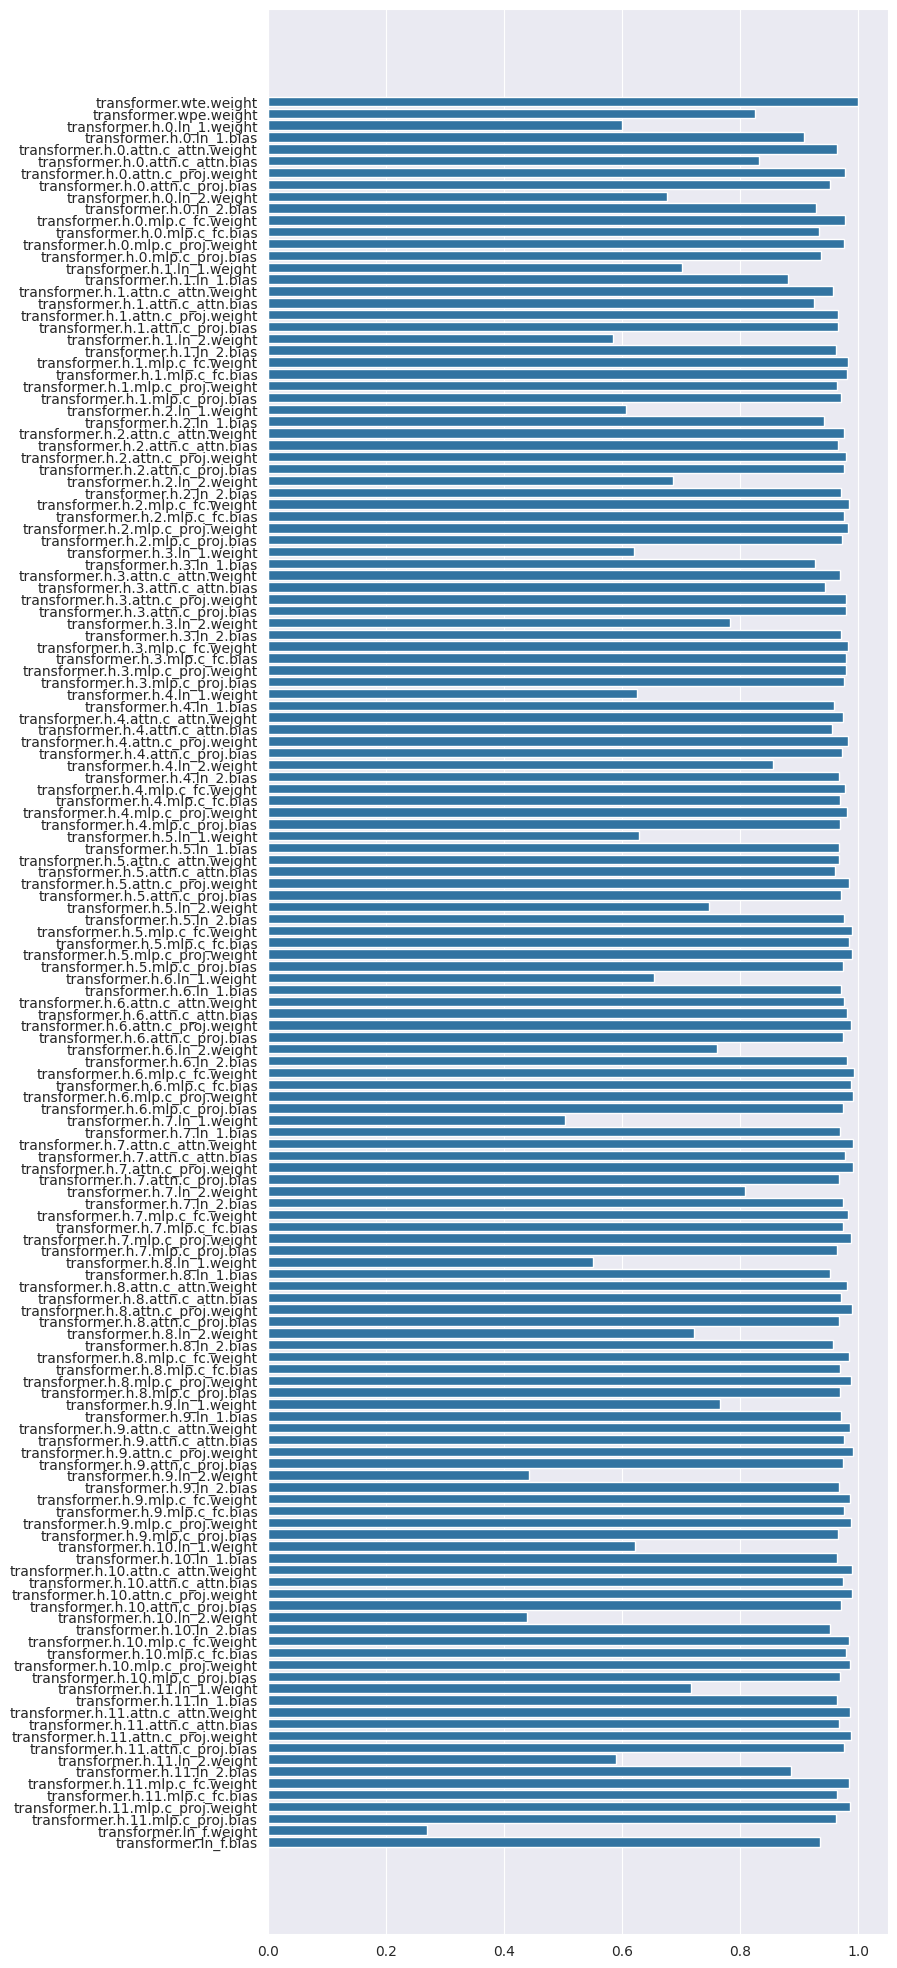

In [17]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(layer_similarity_compared_to_full_gradients.keys()), x = list(layer_similarity_compared_to_full_gradients.values()), orient="h")
plt.plot()

# 1. BM25 Selected

In [231]:
model_score, bm25_score = calculate_score(cosine_similarities_old_structure_combined)
wrong_decisions = get_wrong_decisions(cosine_similarities_old_structure_combined)
mean_similarity = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined)
mean_similarity_score_median = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined, np.median)

print(f"Model score: {model_score}")
print(f"BM25 score: {bm25_score}")
print(f"Mean similarity (average): {mean_similarity}")
print(f"Mean similarity (median): {mean_similarity_score_median}")

Model score: 1.0
BM25 score: 0.99
Mean similarity (average): 0.4714987684084723
Mean similarity (median): 0.4594666335111048


# 1.1 Layer Analysis

In [232]:
accuracy_per_layer = calculate_accuracy_per_layer(cosine_similarities_new_structure)

[]

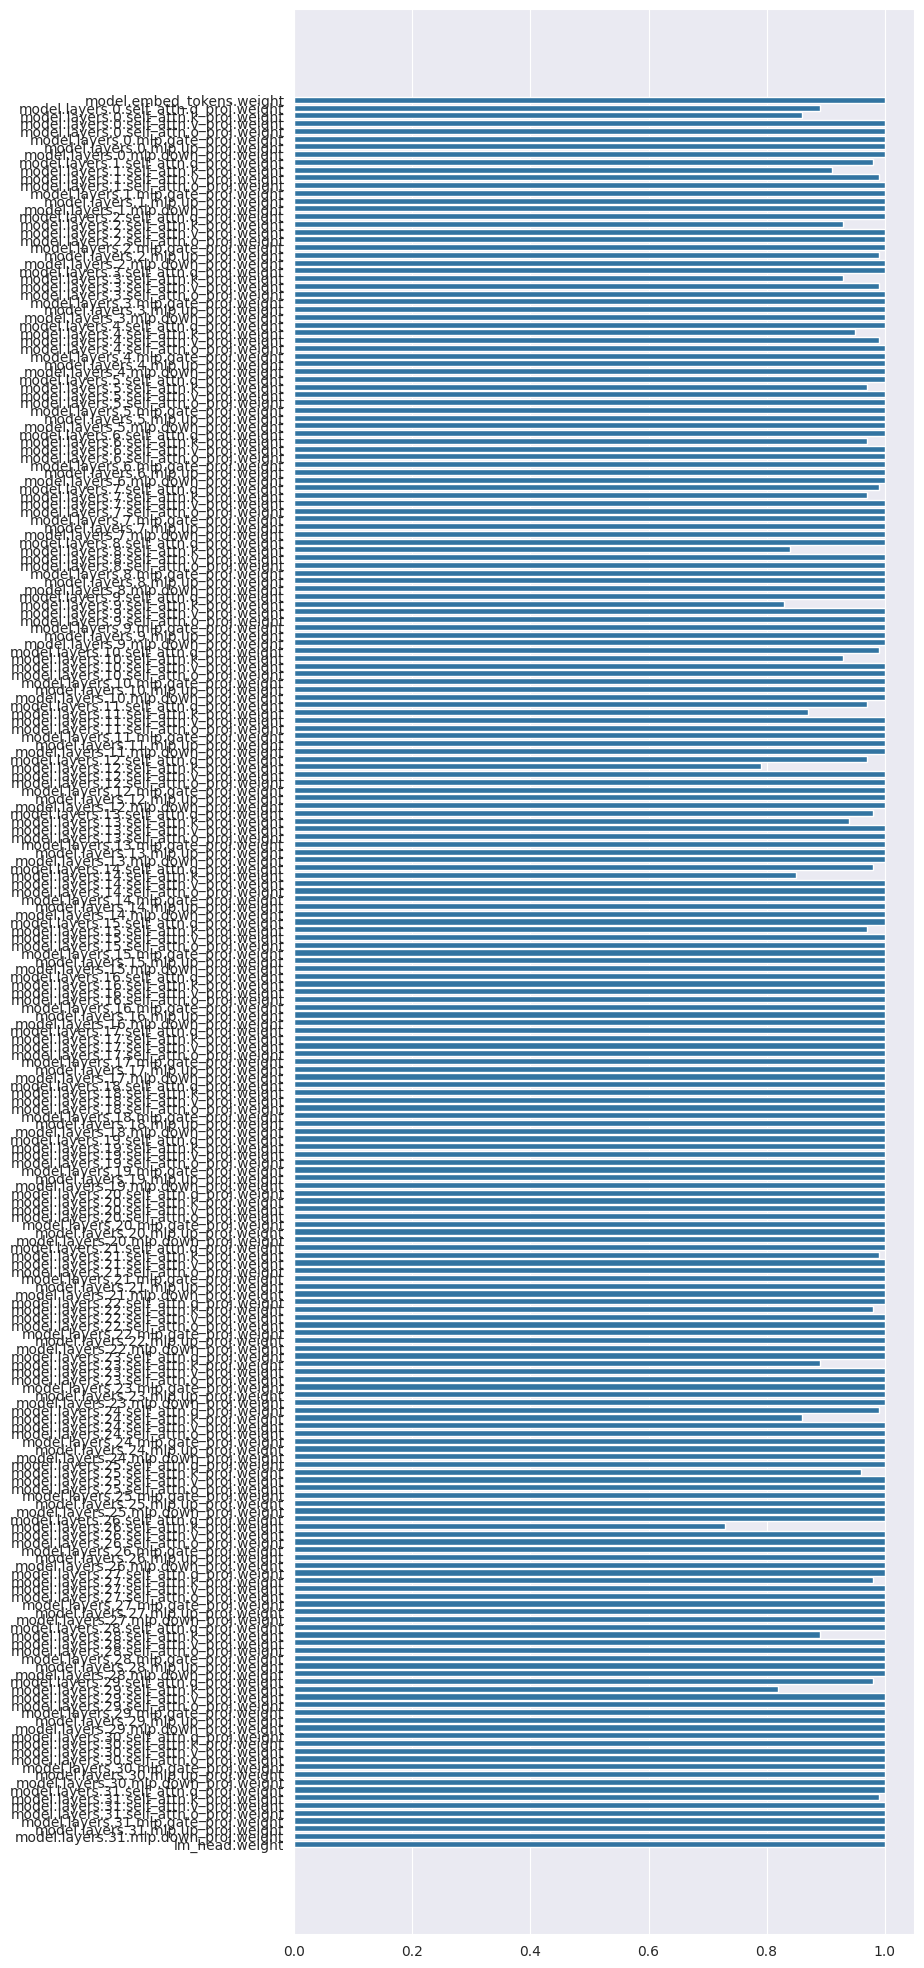

In [233]:
plt.figure(figsize=(8, 25))
sns.barplot(y = list(accuracy_per_layer.keys()), x = list(accuracy_per_layer.values()), orient="h")
plt.plot()

# 2. BM25 Selected Model Generated

In [234]:
cosine_similarities_new_structure_model_generated, cosine_similarities_old_structure_model_generated, cosine_similarities_old_structure_combined_model_generated = get_cosine_similarities(get_dot_product_bm25_selected_model_generated_files, model_to_evaluate, sample_size)

In [235]:
model_score_model_generated, bm25_score_model_generated = calculate_score(cosine_similarities_old_structure_combined_model_generated)
wrong_decisions_model_generated = get_wrong_decisions(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated)
mean_similarity_score_median_model_generated = get_mean_similarity_of_most_similar_samples(cosine_similarities_old_structure_combined_model_generated, np.median)

print(f"Model score: {model_score_model_generated}")
print(f"BM25 score: {bm25_score_model_generated}")
print(f"Mean similarity (average): {mean_similarity_model_generated}")
print(f"Mean similarity (median): {mean_similarity_score_median_model_generated}")

Model score: 0.22
BM25 score: 0.99
Mean similarity (average): 0.06274017872822366
Mean similarity (median): 0.06004889246600584


In [236]:
layer_similarities = dict()

for layer, similarities in cosine_similarities_new_structure_model_generated.items():

    temp_similarities = []

    for paraphrased_id, original_similarities in similarities.items():

        similarity = cosine_similarity(
            X=np.array(list(original_similarities.values())).reshape(1, -1),
            Y=np.array(list(cosine_similarities_old_structure_combined_model_generated[paraphrased_id].values())).reshape(1, -1)
        )
        temp_similarities.append(similarity)

    layer_similarities[layer] = np.mean(temp_similarities)


In [237]:
pprint.pprint(layer_similarities, indent=4, sort_dicts=False)

{   'model.embed_tokens.weight': 0.7607123844560371,
    'model.layers.0.self_attn.q_proj.weight': 0.3595734428411573,
    'model.layers.0.self_attn.k_proj.weight': 0.17990401801498443,
    'model.layers.0.self_attn.v_proj.weight': 0.4293050335229433,
    'model.layers.0.self_attn.o_proj.weight': 0.9315535713336719,
    'model.layers.0.mlp.gate_proj.weight': 0.573788454331703,
    'model.layers.0.mlp.up_proj.weight': 0.7101350304273751,
    'model.layers.0.mlp.down_proj.weight': 0.9458685798359725,
    'model.layers.1.self_attn.q_proj.weight': 0.0970224397421804,
    'model.layers.1.self_attn.k_proj.weight': 0.10063053153571427,
    'model.layers.1.self_attn.v_proj.weight': 0.6715820481689643,
    'model.layers.1.self_attn.o_proj.weight': 0.813059861724287,
    'model.layers.1.mlp.gate_proj.weight': 0.5125094775058981,
    'model.layers.1.mlp.up_proj.weight': 0.6218711330622869,
    'model.layers.1.mlp.down_proj.weight': 0.9558531932941705,
    'model.layers.2.self_attn.q_proj.weight':

# 2.1 Layer Analysis

In [238]:
accuracy_per_layer_model_generated = calculate_accuracy_per_layer(cosine_similarities_new_structure_model_generated)

[]

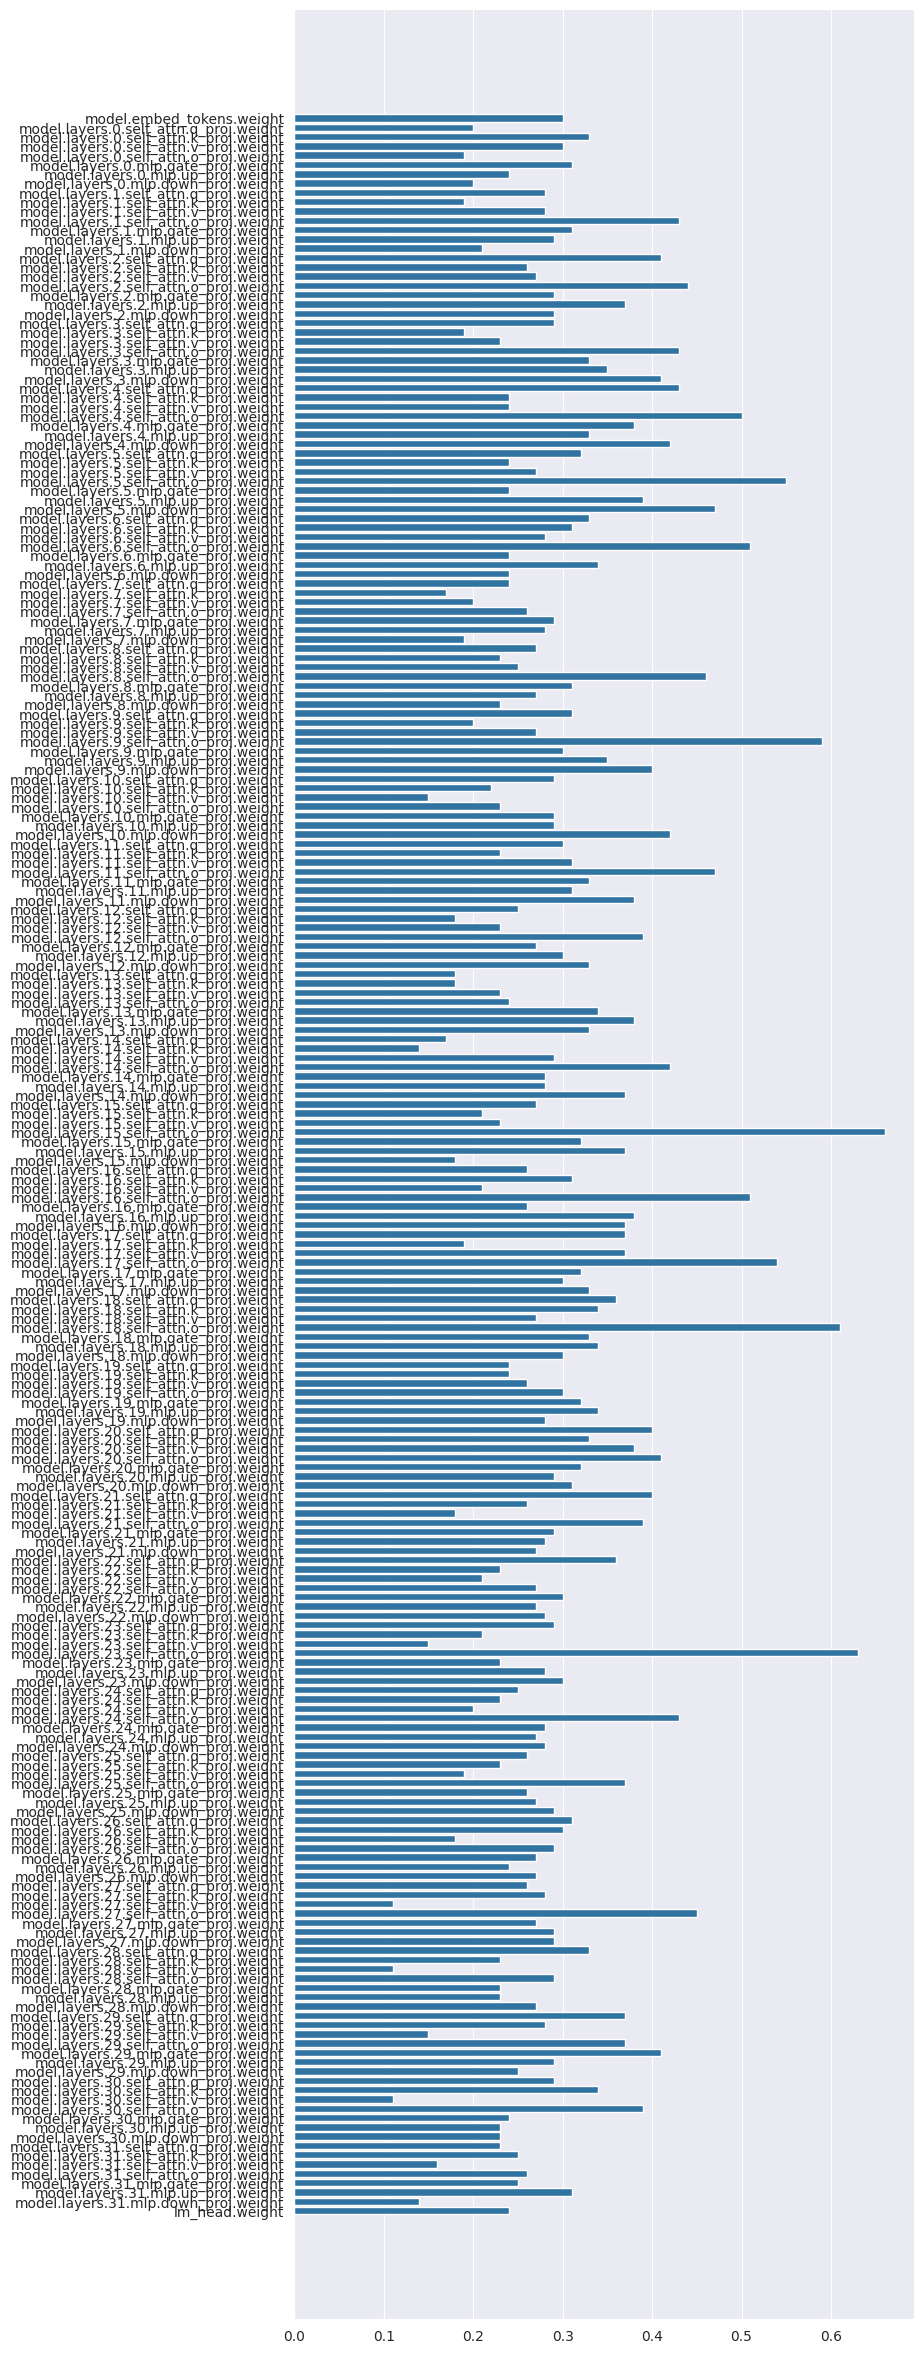

In [239]:
plt.figure(figsize=(8, 30))
sns.barplot(y = list(accuracy_per_layer_model_generated.keys()), x = list(accuracy_per_layer_model_generated.values()), orient="h")
plt.plot()

# 3. Comparison

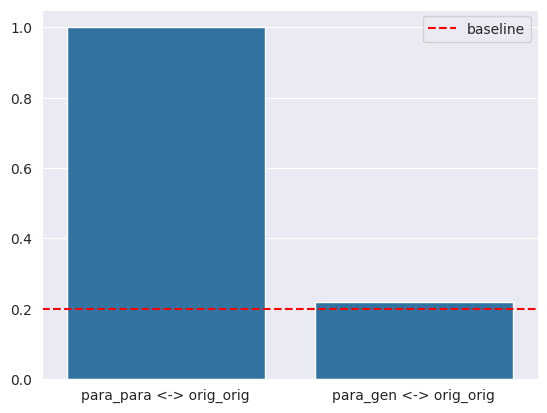

In [240]:
# create bar plot with paraphrased_score, paraphrased_model_generated_score, and horizontal line at 0.2 baseline
sns.barplot(x=["para_para <-> orig_orig", "para_gen <-> orig_orig"], y=[model_score, model_score_model_generated])

plt.axhline(y=0.2, color='r', linestyle='--', label="baseline")
plt.legend()
plt.show()